## Demonstration of scNiche on the mouse liver Seq-Scope data

In this tutorial, we will show you the downstream analytical framework of scNiche for r characterizing the identified cell niches more comprehensively.

The [mouse liver Seq-Scope dataset (*Cell, 2021*)](https://doi.org/10.1016/j.cell.2021.05.010) from 6 normal donors and 4 early-onset liver failure induced by excessive mTORC1 signaling (TD model) donors contains a total of 37,505 cells, and the cell niches have been identified by scNiche.


### Import modules

In [1]:
import scniche as sn
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scniche.pl import *
import warnings
warnings.filterwarnings('ignore')

print("Last run with scNiche version:", sn.__version__)

# set seed
sn.pp.set_seed()

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run with scNiche version: 1.0.0


### Load data

We can download the dataset from figshare, and load it by the `read_h5ad()` function of `scanpy`, or directly download and load the dataset by the `mouse_liver_seq_scope()` of `scniche`

In [2]:
# download data from figshare (https://figshare.com/ndownloader/files/47153125)
# adata = sn.datasets.mouse_liver_seq_scope()
adata = sc.read_h5ad('liver.h5ad.gz')

# normalize first
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 37505 × 20423
    obs: 'tile', 'x', 'y', 'condition', 'celltype', 'cell', 'scNiche', 'group'
    uns: 'log1p'
    obsm: 'X_cn', 'X_cn_norm', 'X_data', 'X_data_nbr', 'X_scVI', 'X_scniche', 'spatial'

### Some visualizations

Visualizing the cellular composition of each cell niche by the `stacked_barplot()` function of `scniche`

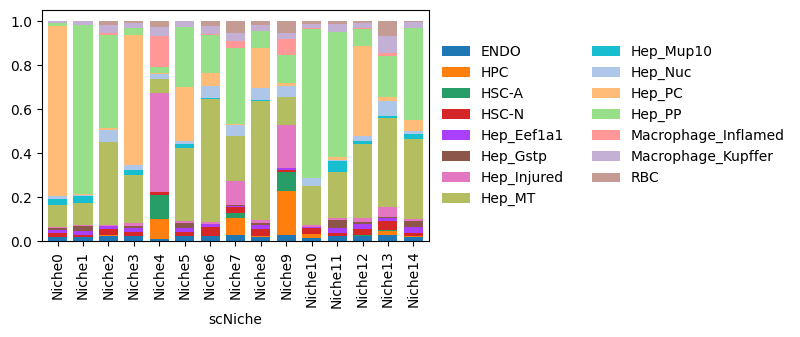

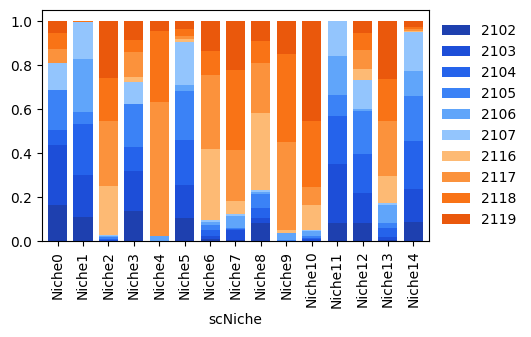

In [3]:
kwargs = {'figsize': (5, 3)}
sn.pl.stacked_barplot(adata, x_axis='scNiche', y_axis='celltype', mode='proportion', palette=palettes.default_20, kwargs=kwargs)
palette_use = ["#1e40af", "#1d4ed8", "#2563eb", "#3b82f6", "#60a5fa", "#93c5fd", "#fdba74", "#fb923c", "#f97316", "#ea580c"]
sn.pl.stacked_barplot(adata, x_axis='scNiche', y_axis='tile', mode='proportion', palette=palette_use, kwargs=kwargs)

Visualizing the spatial distribution of cell populations or cell niches for each slice

<AxesSubplot: title={'center': 'celltype'}, xlabel='spatial1', ylabel='spatial2'>

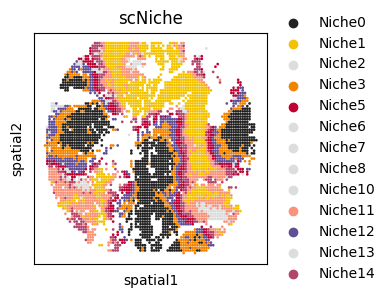

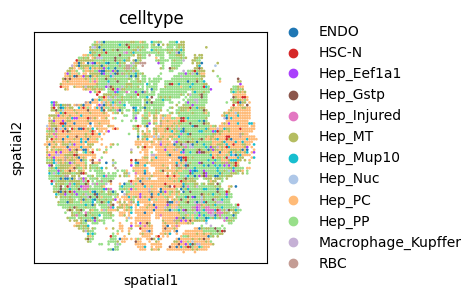

In [4]:
plt.rcParams["figure.figsize"] = (3, 3)
# niches
palette_use = [palettes.default_57[0], palettes.default_57[1], '#dcdddd', palettes.default_57[3], palettes.default_57[5], '#dcdddd', 
               '#dcdddd', '#dcdddd', '#dcdddd', palettes.default_57[11], palettes.default_57[12], '#dcdddd', palettes.default_57[14], ]
sc.pl.embedding(adata[(adata.obs['tile'] == 2103)], basis="spatial", color=['scNiche', ],s=15, show=False, palette=palette_use)

# celltypes
select_niche = ['Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1']
palette_use = [palettes.default_20[i] for i in [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14]]
sc.pl.embedding(adata[(adata.obs['tile'] == 2103)], basis="spatial", color=['celltype', ],s=15, show=False, palette=palette_use)

### Enrichment analysis framework

`scniche` implements a general enrichment analysis framework that can characterize the identified cell niches from various perspectives (including cellular compositions, conditions, and samples, etc.) and compute the corresponding enrichment scores.
We can perform the enrichment analysis from different perspectives by setting the values of the `id_key` and `val_key` parameters. The result is stored in `adata.uns[f"{val_key}_{id_key}_fc"]` and `adata.uns[f"{val_key}_{id_key}_pval"]`.

It is worth noting that the p-value is calculated by the one-sided Mann-Whitney U test.
If the sample size in the dataset is too small (`library_key`),a valid test cannot be implemented.
In this case, we can consider only the enrichment scores and set the parameter `show_pval` to False in the `enrichment_heatmap` function of `scniche` during visualization.

Calculating the enrichment of each cluster (celltype) in group (scNiche)...


Cluster: RBC: 100%|██████████| 15/15 [00:00<00:00, 180.27it/s]


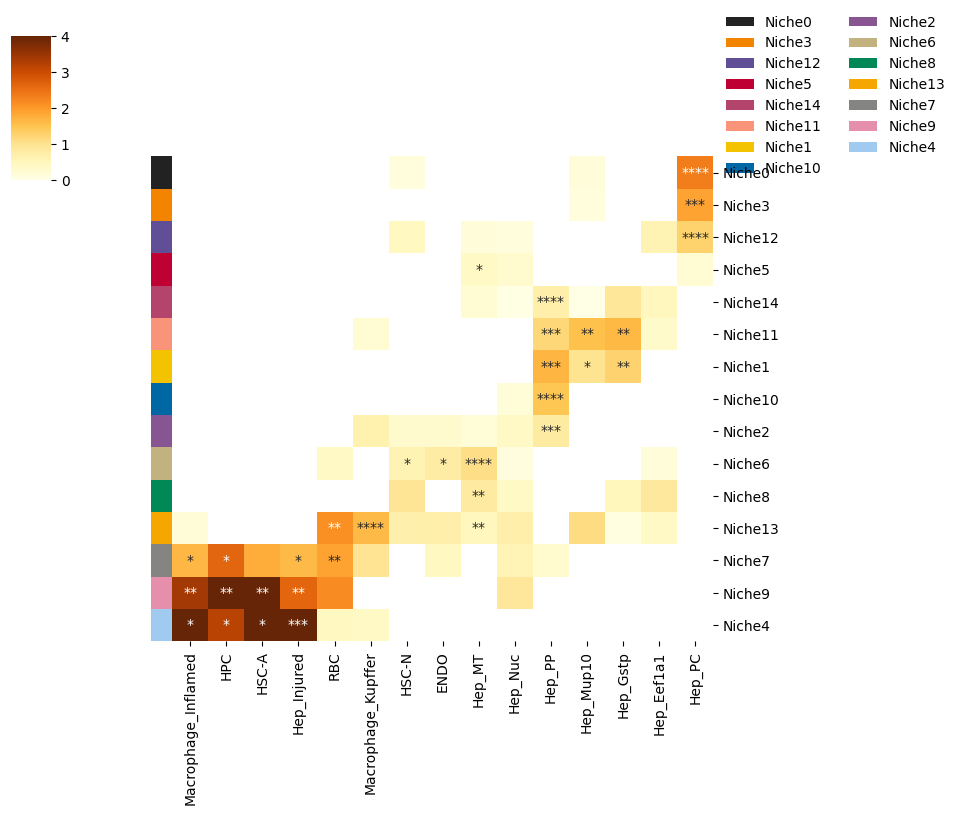

In [5]:
# cell type enrichment
sn.al.enrichment(adata, id_key='celltype', val_key='scNiche', library_key='tile')

# plot
kwargs = {'figsize': (8, 8), 'vmax': 4, 'cmap': 'YlOrBr', 'linewidths': 0, 'linecolor': 'white', }
row_order =[ 'Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1', 'Niche10',  'Niche2', 'Niche6', 'Niche8', 'Niche13', 'Niche7', 'Niche9', 'Niche4', ]
col_order = ['Macrophage_Inflamed', 'HPC', 'HSC-A', 'Hep_Injured', 'RBC', 'Macrophage_Kupffer', 'HSC-N', 'ENDO', 'Hep_MT', 'Hep_Nuc', 'Hep_PP', 'Hep_Mup10','Hep_Gstp', 'Hep_Eef1a1', 'Hep_PC', ]
adata.uns['scNiche_colors'] = palettes.default_57
colors1 = adata.uns['scNiche_colors']
categories1 = adata.obs['scNiche'].cat.categories
palette_use = [colors1[list(categories1).index(cat)] for cat in row_order]
sn.pl.enrichment_heatmap(adata=adata, id_key='celltype', val_key='scNiche', binarized=False, show_pval=True, col_order=col_order, row_order=row_order, 
                         anno_key=None, anno_palette=palette_use, kwargs=kwargs)

Calculating the enrichment of each cluster (scNiche) in group (group)...


Cluster: Niche9: 100%|██████████| 2/2 [00:00<00:00, 185.26it/s]


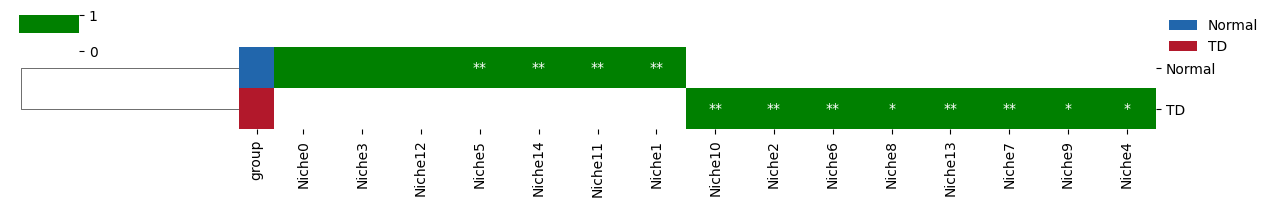

In [6]:
# condition enrichment
sn.al.enrichment(adata, id_key='scNiche', val_key='group', library_key='tile')

# plot
kwargs = {'figsize': (12, 2), 'vmax': 1, 'linewidths': 0, 'linecolor': 'white', }
palette_use = ['#2166AC', '#B2182B', ]
col_order = [ 'Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1', 'Niche10',  'Niche2', 'Niche6', 'Niche8', 'Niche13', 'Niche7', 'Niche9', 'Niche4', ]
sn.pl.enrichment_heatmap(adata=adata, id_key='scNiche', val_key='group', anno_palette=palette_use, binarized=True, col_order=col_order, show_pval=True,
                         anno_key='group', kwargs=kwargs)

Calculating the enrichment of each cluster (scNiche) in group (tile)...


Cluster: Niche9: 100%|██████████| 10/10 [00:00<00:00, 724.50it/s]


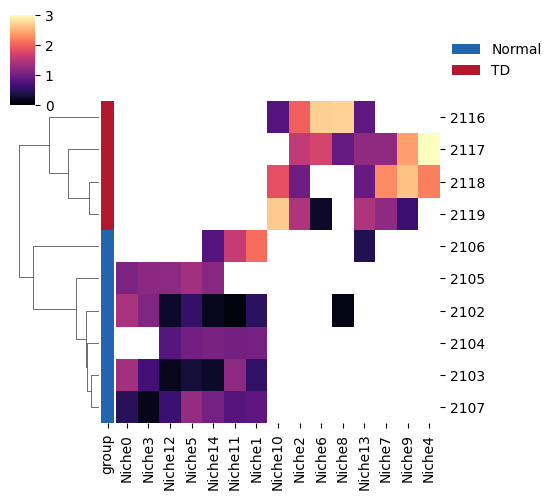

In [7]:
# sample enrichment
sn.al.enrichment(adata, id_key='scNiche', val_key='tile', library_key=None)

# plot
kwargs = {'figsize': (5, 5), 'vmax': 3, 'cmap': 'magma'}
col_order = [ 'Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1', 'Niche10',  'Niche2', 'Niche6', 'Niche8', 'Niche13', 'Niche7', 'Niche9', 'Niche4', ]
palette_use = ['#2166AC', '#B2182B', ]
sn.pl.enrichment_heatmap(adata=adata, id_key='scNiche', val_key='tile', binarized=False, col_order=col_order, row_order=None, 
                         anno_key='group', anno_palette=palette_use, kwargs=kwargs)

### Differential expression gene analysis

We can calculate the differential expression genes within cell niches by the `rank_genes_groups` function of `scanpy`.
Subsequently, the average expression values of this differential expression genes in each niche can be calculated using the `average_exp` function of `scniche`.

In this example, we found that the 7 cell niches (Niche 0, 3, 12, 5, 14, 11, and 1) enriched in normal livers exhibited spatial continuity,
encompassing the zonation patterns from the central vein to the portal node, and differentially expressed genes (adjusted p-value < 0.05) within these 7 niches also showed a pronounced spatial expression pattern of zones.

In [8]:
select_niche = ['Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1']
adata2 = adata[adata.obs['scNiche'].isin(select_niche)].copy()
sc.tl.rank_genes_groups(adata2, "scNiche", method="wilcoxon")

result = adata2.uns['rank_genes_groups']
groups = result['names'].dtype.names

df_results = pd.DataFrame()
for i in groups:
    df_tmp = pd.DataFrame({'gene': result['names'][i], 'pvals_adj': result['pvals_adj'][i], 'logfoldchanges': result['logfoldchanges'][i], 'niche': i})
    df_results = pd.concat([df_results, df_tmp])
    
df_results = df_results[df_results['pvals_adj'] < 0.05]
df_results = df_results[df_results['logfoldchanges'] > 0]

In [9]:
def merge_lists(*lists):
    merged_list = []
    seen = set()

    for lst in lists:
        for element in lst:
            if element not in seen:
                merged_list.append(element)
                seen.add(element)

    return merged_list


list1 = df_results.loc[df_results['niche'] == 'Niche0']['gene'].tolist()
list2 = df_results.loc[df_results['niche'] == 'Niche3']['gene'].tolist()
list3 = df_results.loc[df_results['niche'] == 'Niche12']['gene'].tolist()
gene_list1 = merge_lists(list1, list2, list3, )

list4 = df_results.loc[df_results['niche'] == 'Niche1']['gene'].tolist()
list5 = df_results.loc[df_results['niche'] == 'Niche11']['gene'].tolist()
list6 = df_results.loc[df_results['niche'] == 'Niche14']['gene'].tolist()
list7 = df_results.loc[df_results['niche'] == 'Niche5']['gene'].tolist()
gene_list2 = merge_lists(list4, list5, list6, list7)
gene_list2 = gene_list2[::-1]

gene_list1 = [x for x in gene_list1 if x not in gene_list2]
gene_list = gene_list1 + gene_list2

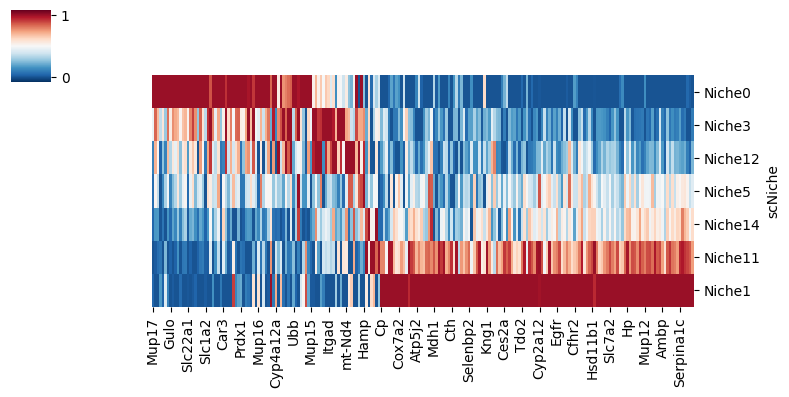

In [10]:
select_niche = ['Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1']
df = sn.al.average_exp(adata2, layer_key='data', id_key='scNiche', val_key='scNiche', select_idx=None, select_val=select_niche)

sns.clustermap(df.loc[select_niche, gene_list], cmap='RdBu_r',linewidths=0, linecolor='white', figsize=(8, 4), row_cluster=False, col_cluster=False, 
               vmax=1.08, vmin=-0.08, standard_scale=True)

### Multi-sample analysis framework

For large-scale datasets containing multiple samples under different conditions, `scniche` implements a multi-sample analysis framework that enables differential analyses at the sample scale,
such as the comparison of specific niches across different conditions, or the comparison of specific cell populations across different niches,
which holds the promise of identifying clinically relevant key niches or cell populations from large-scale datasets while avoiding the influence of individual outliers.

#### Calculate the cellular composition
We can calculate the cellular composition for each niche within each sample by the `calculate_composition_multi` function of `scNiche`,
and the result is stored in `adata.uns["composition_multi"]`.

By default, to avoid the effect of outliers, for each niche, only samples with a proportion of that niche exceeding 5% are considered.
We can set the value of `cutoff` parameter to change the threshold.

In [11]:
library_key = 'tile'
niche_key = 'scNiche'
celltype_key = 'celltype'

sn.al.calculate_composition_multi(adata2, library_key=library_key, niche_key=niche_key, celltype_key=celltype_key, cutoff=0.05)
adata2.uns["composition_multi"].head()

,tile,scNiche,Niche_ratio,Hep_PC_ratio,Hep_MT_ratio,Hep_Mup10_ratio,ENDO_ratio,Hep_Eef1a1_ratio,Hep_PP_ratio,HSC-N_ratio,Hep_Gstp_ratio,Macrophage_Kupffer_ratio,Hep_Nuc_ratio,Hep_Injured_ratio,RBC_ratio,HSC-A_ratio,Macrophage_Inflamed_ratio,HPC_ratio
0,2102,Niche0,0.251397,0.753968,0.109524,0.039683,0.022222,0.015873,0.012698,0.011111,0.011111,0.009524,0.009524,0.003175,0.001587,NaN,NaN,NaN
1,2102,Niche1,0.227055,0.001757,0.107206,0.024605,0.014060,0.026362,0.755712,0.012302,0.031634,0.014060,0.001757,0.010545,NaN,NaN,NaN,NaN
2,2102,Niche3,0.161213,0.539604,0.274752,0.032178,0.022277,0.034653,0.022277,0.019802,0.014851,0.017327,0.009901,0.007426,0.004950,NaN,NaN,NaN
3,2102,Niche12,0.102953,0.368217,0.399225,0.031008,0.019380,0.034884,0.089147,0.011628,0.003876,0.027132,0.011628,0.003876,NaN,NaN,NaN,NaN
4,2102,Niche11,0.090583,0.022026,0.242291,0.008811,0.013216,0.022026,0.621145,0.008811,0.039648,0.013216,NaN,0.004405,0.004405,NaN,NaN,NaN


We can visualize the proportion of any cell populations for each niche within each sample by the `multi_boxplot` function of `scniche`.
For example, we found that the proportion of periportal hepatocytes (Hep_PP) and pericentral hepatocytes (Hep_PC) showed a monotonous increase or decrease in 7 niches.

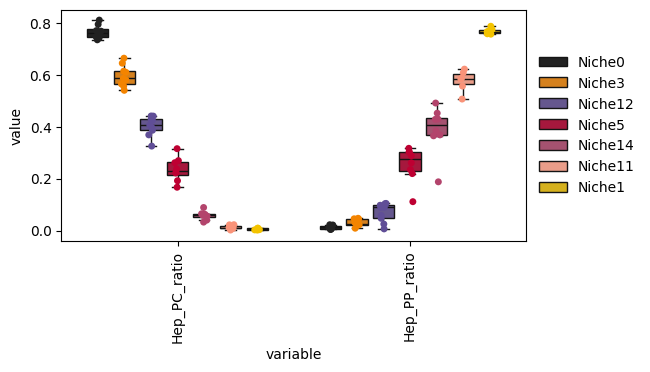

In [12]:
plt.rcParams["figure.figsize"] = (6, 3)
niche_list = ['Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1']
sn.pl.multi_boxplot(adata=adata2, library_key='tile', show_list=['Hep_PC', 'Hep_PP', ], mode='composition', 
                    show_scatter=True, order=niche_list, palette=[palettes.default_57[i] for i in [0, 3, 12, 5, 14, 11, 1]])

To illustrate the changes in cell proportions across multiple niches (typically >= 3), we can use the `multi_lineplot` function of `scniche`,
which provides a more intuitive visualization.

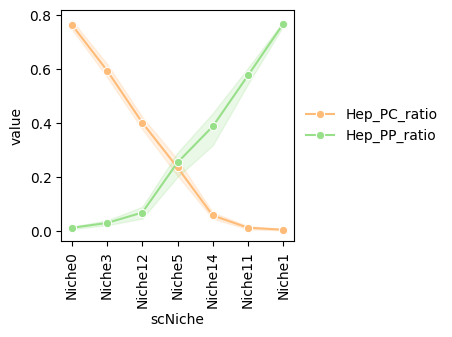

In [13]:
plt.rcParams["figure.figsize"] = (3, 3)
niche_list = ['Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1']
sn.pl.multi_lineplot(adata=adata2, library_key='tile', show_list=['Hep_PC', 'Hep_PP', ], mode='composition', 
                    order=niche_list, palette=[palettes.default_20[i] for i in [10, 11]])

#### Calculate the phenotypic characteristics
We can calculate the phenotypic characteristics for each niche within each sample by the `calculate_average_exp_multi` function of `scNiche`,
and the result is stored in `adata.uns["expression_multi"]`.

By default, to avoid the effect of outliers, for each niche, only samples with a proportion of that niche exceeding 5% are considered.
We can set the value of `cutoff` parameter to change the threshold. Besides, we can set the value of `selected_celltype` parameter to
calculate the average phenotypic characteristics of all cells belonging to the selected cell populations, otherwise `selected_celltype=None`, `scniche`
will calculate the average phenotypic characteristics of all cells belonging to niches.

In this example, from Niche 0 to Niche 1, we observed a gradual decrease in the expression of the pericentral genes such as Cyp2e1.
Conversely, the expression of the periportal genes such as Cyp2f2 exhibited a gradual increase.

In [14]:
library_key = 'tile'
niche_key = 'scNiche'
celltype_key = 'celltype'

sn.al.calculate_average_exp_multi(adata2, layer_key='data', library_key=library_key, niche_key=niche_key, celltype_key=celltype_key, 
                                  gene_list=gene_list, selected_celltype=None, cutoff=0.05)
adata2.uns['expression_multi'].head()

,tile,scNiche,Niche_ratio,Mup17,Cyp2c29,Cyp1a2,Mup9,Cyp2a5,Cyp3a11,Apoe,...,Hsd17b13,Fgb,Pck1,Fga,Serpina1c,Serpina1e,Cyp2f2,Mup3,Mup20,Alb
0,2102,Niche0,0.251397,3.016366,3.165441,2.024903,2.247860,1.308051,4.309904,5.381613,...,0.562137,2.718228,1.646722,2.957385,3.768360,2.324869,1.676095,4.626377,3.572437,6.472378
1,2102,Niche1,0.227055,1.347065,1.470073,0.681930,1.185563,0.313638,3.863366,5.227324,...,1.267154,3.397107,2.259360,3.496953,4.161448,3.602183,3.137612,5.154489,4.778705,6.980240
2,2102,Niche3,0.161213,2.100547,2.969939,1.636240,1.522429,0.730871,4.046980,5.320291,...,0.590693,2.803703,1.675360,3.159718,3.877545,2.707876,1.823318,4.623589,3.641318,6.468164
3,2102,Niche12,0.102953,1.446319,2.602856,1.442304,1.273879,0.381993,3.918025,5.284259,...,0.680457,2.996247,1.821346,3.173913,3.995923,2.949590,2.093962,4.696248,3.682534,6.556813
4,2102,Niche11,0.090583,1.360826,1.652809,0.893462,1.295120,0.296913,3.805506,5.219395,...,1.361616,3.253701,2.062467,3.546352,4.100798,3.601937,3.000446,5.039079,4.499286,6.853433


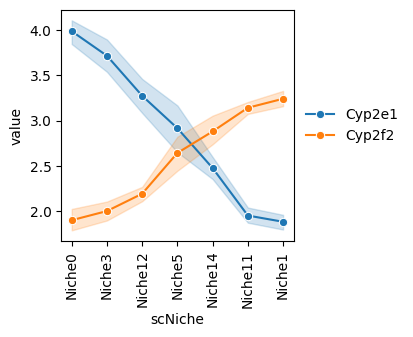

In [15]:
show_genes = ['Cyp2e1', 'Cyp2f2', ]
niche_list = ['Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1']
plt.rcParams["figure.figsize"] = (3, 3)
sn.pl.multi_lineplot(adata=adata2, library_key='tile', show_list=show_genes, mode='expression', order=niche_list,)

Visually, we can observe the partial remodeling of the zonation patterns from the central vein to the portal node in TD livers compared to normal livers.
We can therefore perform further analysis by calculating the spatial connectivity between niches of different groups.

The `spatial_link` function of `scniche` is developed based on the `spatial_neighbors` function of `squidpy`.
We can first calculate the spatial connectivity between niches on each slice, then group the results and calculate the average spatial connectivity.

<AxesSubplot: title={'center': 'scNiche'}, xlabel='spatial1', ylabel='spatial2'>

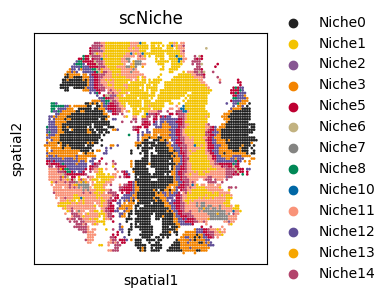

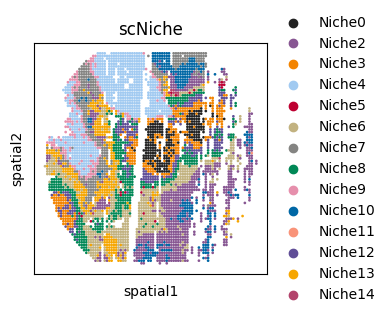

In [16]:
plt.rcParams["figure.figsize"] = (3, 3)
# normal
palette_use = [palettes.default_57[i] for i in [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14]]
sc.pl.embedding(adata[(adata.obs['tile'] == 2103)], basis="spatial", color=['scNiche', ],s=15, show=False, palette=palette_use)

# td
palette_use = [palettes.default_57[i] for i in [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
sc.pl.embedding(adata[(adata.obs['tile'] == 2117)], basis="spatial", color=['scNiche', ],s=15, show=False, palette=palette_use)

In [17]:
from tqdm import tqdm
df = pd.DataFrame()
for i in tqdm(list(set(adata.obs['tile']))):
    adata_tmp = adata[adata.obs['tile'] == i].copy()
    sn.al.spatial_link(adata_tmp, cluster_key='scNiche')
    
    # row: from; columns: to
    a = adata_tmp.uns['scNiche_spatial_link']
    np.fill_diagonal(a.values, np.nan)
    b = pd.melt(a, var_name='to', value_name='link_number')
    b['from'] = list(a.index) * a.shape[1]
    b['tile'] = i
    df = pd.concat([df, b], axis=0)
    
df['tile'] = df['tile'].astype('category')
df['to'] = df['to'].astype('str')

df.head()

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


,to,link_number,from,tile
0,Niche0,NaN,Niche0,2116
1,Niche0,0.0,Niche1,2116
2,Niche0,0.0,Niche2,2116
3,Niche0,17.0,Niche3,2116
4,Niche0,0.0,Niche5,2116


In [18]:
df1 = df.loc[df['tile'].isin([2102, 2103, 2104, 2105, 2106, 2107])]
df2 = df.loc[df['tile'].isin([2116, 2117, 2118, 2119])]

def norm_link(df):
    df_new = pd.DataFrame()
    df_group = df.groupby(['from', 'to']).mean()
    for i in list(set(adata.obs['scNiche'])):
        tmp = pd.DataFrame({i: list(df_group.loc[i]['link_number'].values)})
        tmp.index = list(df_group.loc[i]['link_number'].index)
        df_new = pd.concat([df_new, tmp], axis=1)
    
    return df_new

df_normal = norm_link(df1)
df_td = norm_link(df2)

df_normal.head(5)

,Niche10,Niche9,Niche3,Niche12,Niche2,Niche7,Niche14,Niche11,Niche4,Niche8,Niche5,Niche6,Niche13,Niche1,Niche0
Niche0,0.000000,1.0,470.600000,29.600000,0.000000,0.000000,1.600000,1.200000,NaN,3.200000,2.600000,0.000000,0.000000,1.000000,NaN
Niche1,72.833333,0.0,2.666667,2.500000,3.666667,7.166667,57.166667,601.833333,0.0,0.666667,3.500000,0.166667,0.166667,NaN,1.0
Niche10,NaN,0.0,0.000000,0.000000,6.333333,1.000000,23.666667,47.666667,0.0,0.166667,0.000000,0.000000,0.000000,72.833333,0.0
Niche11,47.666667,1.5,2.000000,2.666667,15.000000,65.666667,422.333333,NaN,0.0,1.833333,25.666667,3.500000,28.833333,601.833333,1.2
Niche12,0.000000,0.0,420.333333,NaN,0.000000,0.000000,14.833333,2.666667,0.0,114.833333,315.333333,2.500000,1.166667,2.500000,29.6


Specifically, we found that niches proximal to the central vein observed in normal livers (Niche 0, 3 and 12) were also present in TD liver,
whereas niches proximal to the portal node were altered, despite no significant changes in their cellular composition

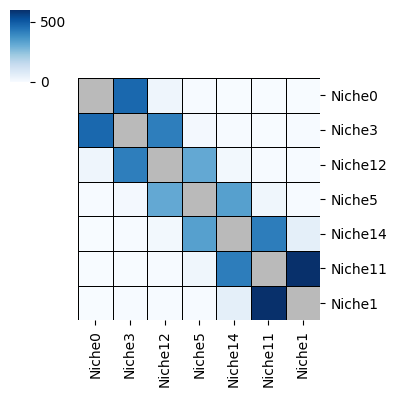

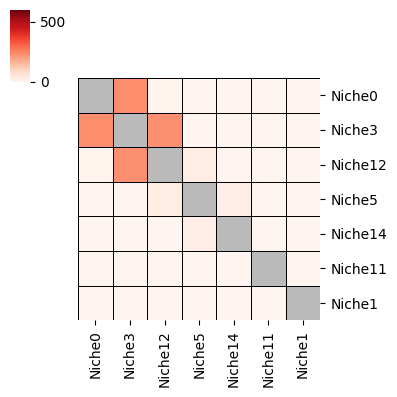

In [19]:
niche_normal = ['Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1', ]
niche_td = ['Niche0', 'Niche3', 'Niche12', 'Niche8', 'Niche6', 'Niche2', 'Niche10', ]

cmap1 = plt.get_cmap("Blues")
cmap1.set_bad(color="#bababa")
cmap2 = plt.get_cmap("Reds")
cmap2.set_bad(color="#bababa")

sns.clustermap(df_normal.loc[niche_normal, niche_normal], cmap=cmap1, linewidths=0.5, linecolor='black', figsize=(4, 4), 
               row_cluster=False, col_cluster=False, vmin=0, vmax=600)

sns.clustermap(df_td.loc[niche_normal, niche_normal], cmap=cmap2, linewidths=0.5, linecolor='black', figsize=(4, 4), 
               row_cluster=False, col_cluster=False, vmin=0, vmax=600)

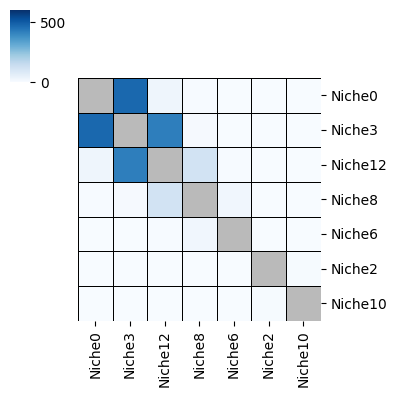

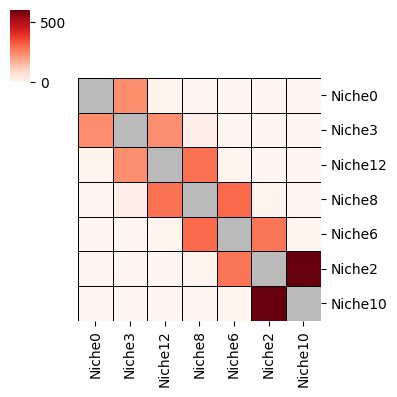

In [20]:
sns.clustermap(df_normal.loc[niche_td, niche_td], cmap=cmap1, linewidths=0.5, linecolor='black', figsize=(4, 4), 
               row_cluster=False, col_cluster=False, vmin=0, vmax=600)

sns.clustermap(df_td.loc[niche_td, niche_td], cmap=cmap2, linewidths=0.5, linecolor='black', figsize=(4, 4), 
               row_cluster=False, col_cluster=False, vmin=0, vmax=600)

We can further perform the differential expression analysis between Niche 1 and Niche 10, which were located at the portal node in normal and TD livers, respectively.

In [21]:
select_niche = ['Niche1', 'Niche10']
adata3 = adata[adata.obs['scNiche'].isin(select_niche)].copy()
sc.tl.rank_genes_groups(adata3, "scNiche", method="wilcoxon")

result = adata3.uns['rank_genes_groups']
groups = result['names'].dtype.names

df_results = pd.DataFrame()
for i in groups:
    df_tmp = pd.DataFrame({'gene': result['names'][i], 'pvals_adj': result['pvals_adj'][i], 'logfoldchanges': result['logfoldchanges'][i], 'niche': i})
    df_results = pd.concat([df_results, df_tmp])
    
df_results = df_results[df_results['pvals_adj'] < 0.05]
df_results = df_results[df_results['logfoldchanges'] > 0]

In [22]:
df_results.sort_values('logfoldchanges', ascending=False).groupby('niche').head(10)

,gene,pvals_adj,logfoldchanges,niche
94,Mup14,6.180940e-04,3.696288,Niche1
0,Gpx3,0.000000e+00,3.250658,Niche10
50,Mup4,1.185283e-16,3.218637,Niche1
1,Mup20,0.000000e+00,2.964389,Niche1
43,Mup7,4.077942e-20,2.956424,Niche1
203,Wfdc15b,1.959192e-02,2.888614,Niche10
2,Serpina1e,0.000000e+00,2.837774,Niche1
22,Traf5,4.128467e-43,2.837365,Niche1
144,Slpi,5.920689e-05,2.684009,Niche10
158,Wfdc12,2.654800e-04,2.625314,Niche10


`scniche` provides the `multi_linrplot_group` function to visualize the spatial variation trends of niches from different groups.
In this example, we found that these differential expression genes reflecting phenotypic changes during liver injury between Niche 1 and Niche 10 exhibited spatial expression gradients similar to those of pericentral or periportal markers.

In [23]:
select_niche = ['Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1', 'Niche8', 'Niche6', 'Niche2', 'Niche10']
library_key = 'tile'
niche_key = 'scNiche'
celltype_key = 'celltype'
gene_list = list(set(df_results['gene']))

adata4 = adata[adata.obs['scNiche'].isin(select_niche)].copy()
sn.al.calculate_average_exp_multi(adata4, layer_key='data', library_key=library_key, niche_key=niche_key, celltype_key=celltype_key, 
                                  gene_list=gene_list, selected_celltype=None, cutoff=0.05)

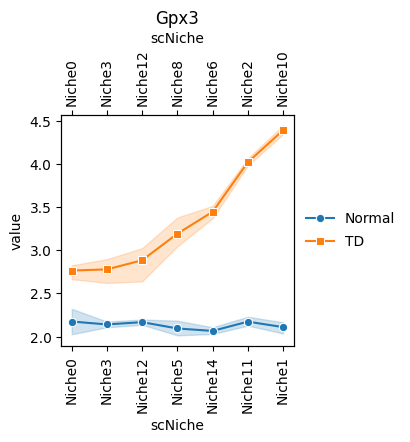

In [24]:
group_normal = [2102, 2103, 2104, 2105, 2106, 2107]
group_td = [2116, 2117, 2118, 2119]
group_normal_niche = ['Niche0', 'Niche3', 'Niche12', 'Niche5', 'Niche14', 'Niche11', 'Niche1']
group_td_niche = ['Niche0', 'Niche3', 'Niche12', 'Niche8', 'Niche6', 'Niche2', 'Niche10']

show_gene = 'Gpx3'
plt.rcParams["figure.figsize"] = (3, 3)
sn.pl.multi_linrplot_group(
    adata4, 
    library_key='tile', 
    show=show_gene, 
    group1=group_normal, 
    group2=group_td, 
    group1_niche=group_normal_niche, 
    group2_niche=group_td_niche,
    mode='expression',
    group_name_list=['Normal', 'TD'],
)

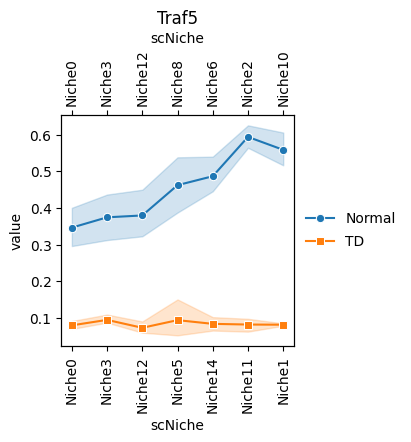

In [25]:
show_gene = 'Traf5'
plt.rcParams["figure.figsize"] = (3, 3)
sn.pl.multi_linrplot_group(
    adata4, 
    library_key='tile', 
    show=show_gene, 
    group1=group_normal, 
    group2=group_td, 
    group1_niche=group_normal_niche, 
    group2_niche=group_td_niche,
    mode='expression',
    group_name_list=['Normal', 'TD'],
)